# SMCN application for air quality predictions
This notebook visualize trainings demonstrated in the `demo.py` script.

In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from oze.utils import plot_predictions
from oze.dataset import OzeDataset
from src.metrics import compute_cost, cumulative_cost
from src.utils import plot_range, uncertainty_estimation, boxplotprediction

# Set manual seeds
torch.manual_seed(1)
np.random.seed(1)

# Reload python packages when changed
%load_ext autoreload
%autoreload 2

In [2]:
# Load demo's models and dataloaders
from demo import model, df, args, dataloader_train, dataloader_val
dict(vars(args))

/home/mrmojo/Code/these/smcl/oze/utils.py:69: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  occupancy = int(date < date_start_lockdown)
/home/mrmojo/Code/these/smcl/oze/utils.py:72: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_end_lockdown < date:


{'__module__': 'demo',
 'dataset_path': 'datasets/data_2020_2021.csv',
 'T': 168,
 'd_emb': 8,
 'N': 20,
 'batch_size': 16,
 'epochs': 10,
 'epochs_smcn': 10,
 'train': ['classic'],
 'save_path': None,
 'load_path': 'weights/pretrain.pt',
 '__dict__': <attribute '__dict__' of 'args' objects>,
 '__weakref__': <attribute '__weakref__' of 'args' objects>,
 '__doc__': None}

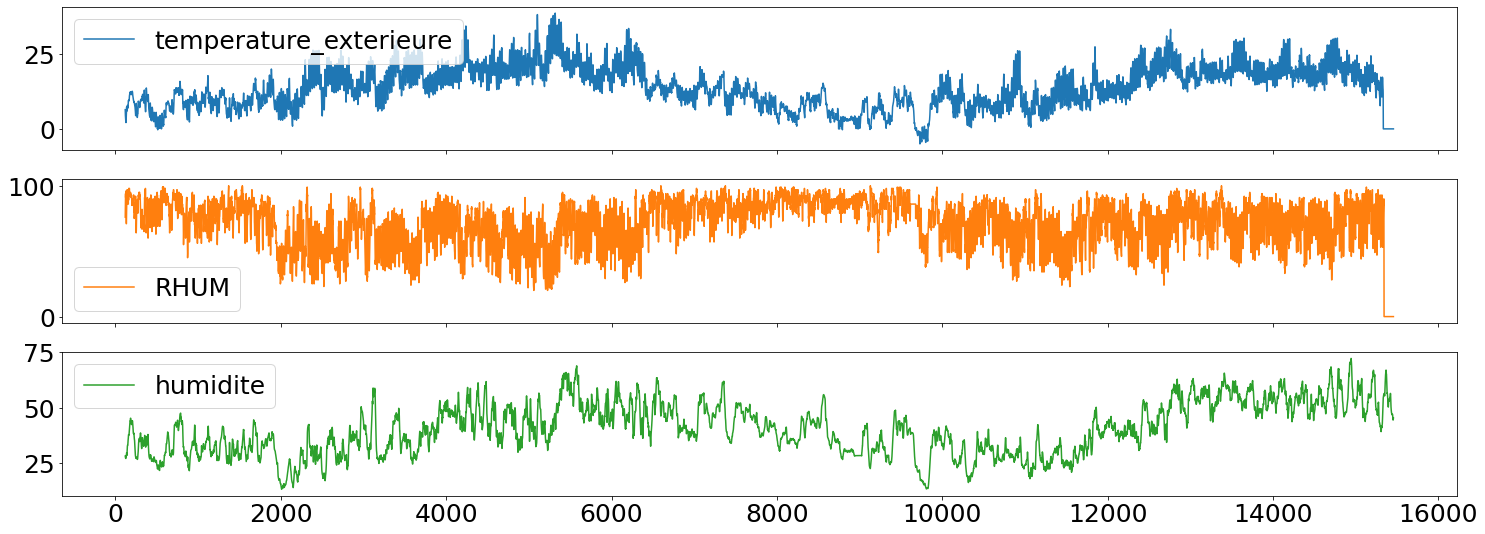

In [3]:
_ = df[[*OzeDataset.input_columns, *OzeDataset.target_columns]].plot(subplots=True, figsize=(25, 3*(len(OzeDataset.input_columns + OzeDataset.target_columns))))

In [4]:
model.load_state_dict(torch.load("weights/pretrain.pt"))

<All keys matched successfully>

### Plot predictions

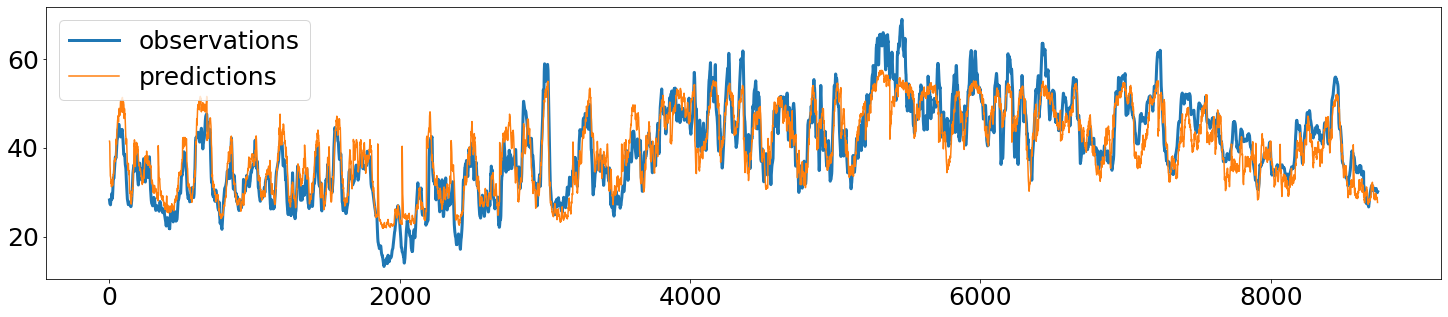

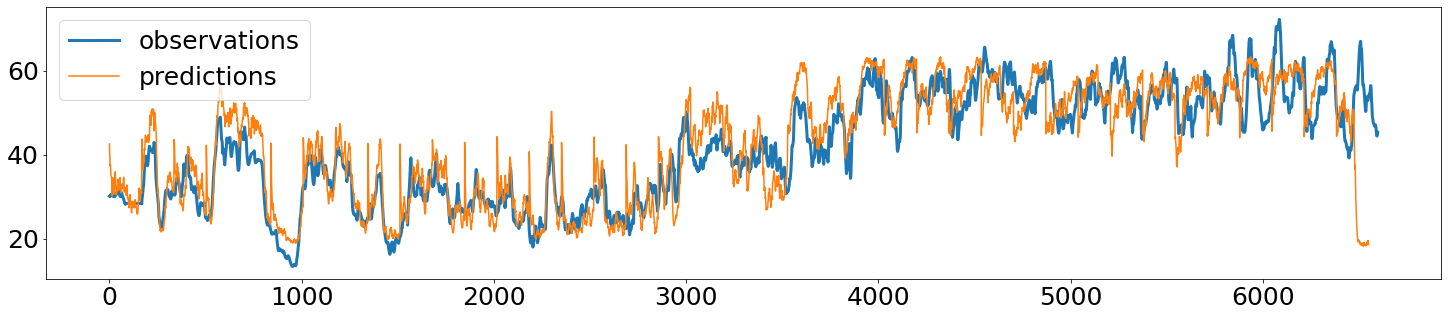

In [5]:
plot_predictions(model, dataloader_train.dataset)
plot_predictions(model, dataloader_val.dataset)

### Train

In [6]:
# model.load_state_dict(torch.load("weights/presentation_oze_2021_pretrain.pt"))

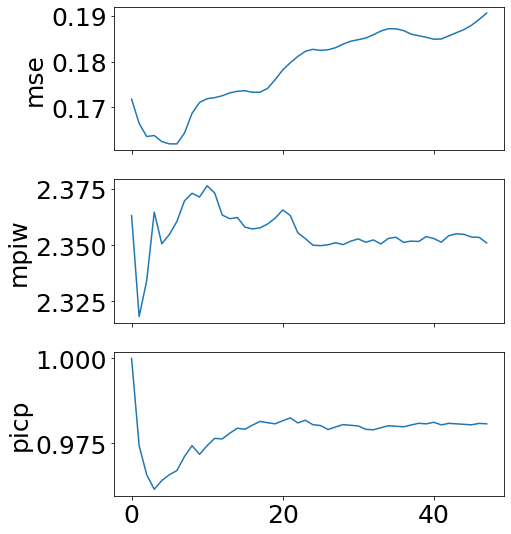

In [7]:
criterias = {
    "mse": model,
    "mpiw": model.uncertainty_estimation,
    "picp": model.uncertainty_estimation,
}

_, axes = plt.subplots(len(criterias), 1, sharex=True, squeeze=False, figsize=(7, 3*len(criterias)))

for (criteria, criteria_model), ax in zip(criterias.items(), axes[:, 0]):
    ax.plot(cumulative_cost(criteria_model, dataloader_val, criteria=criteria, reduction="mean"))
    ax.set_ylabel(criteria)

### Evaluate predictions on train

In [8]:
# Generate inference sample
idx = np.random.randint(0, len(dataloader_val.dataset))
u, y = dataloader_val.dataset[idx]
u = u.unsqueeze(1)
y = y.unsqueeze(1)

# Set target idx for vialization (0 for CO2 levels)
idx_out = 0

#### Traditional inference on train with new weights

0.21 \pm 0.1116


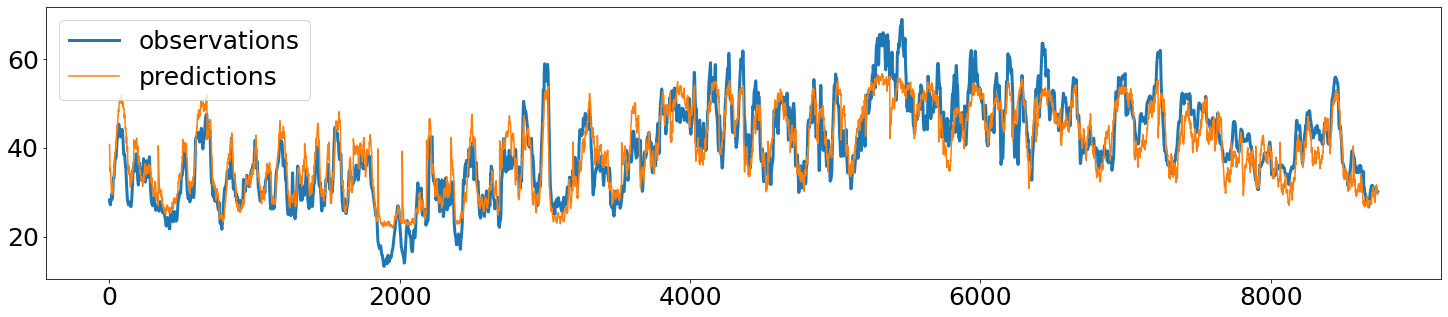

In [9]:
# Plot inference with original model, print cost
model.N=1
plot_predictions(model, dataloader_train.dataset)
losses = compute_cost(model, dataloader_train, criteria="mse")
print(f"{losses.mean():.2f} \pm {losses.var():.4f}")
model.N=args.N

#### Smoother predictions

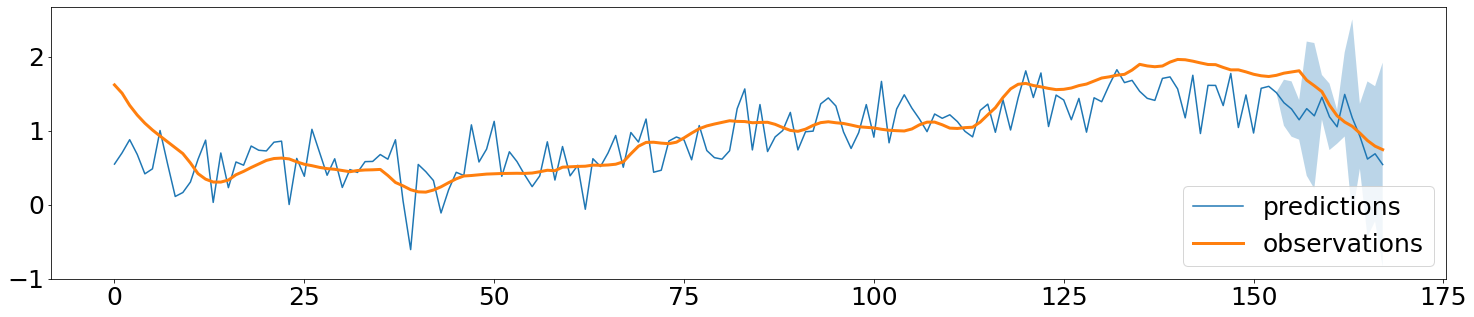

In [10]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I).numpy()

plot_range(netout[:, 0, :, idx_out], label='predictions')
plt.plot(y[:, 0, idx_out], lw=3, label='observations')
plt.legend()
plt.show()

#### Predictions at $t+1$

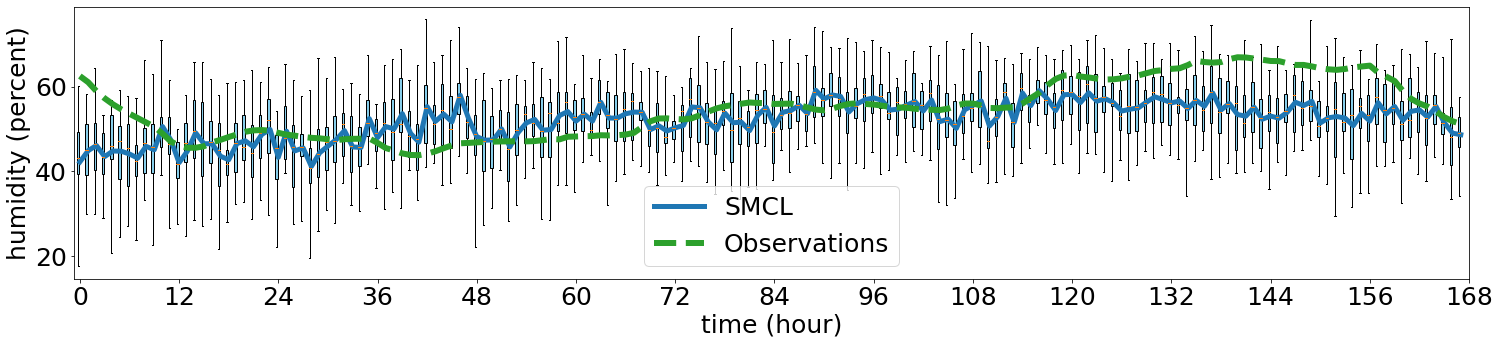

In [11]:
start_day = 0
end_day = start_day+7
day_hide = 0
tick_step = 12
burnin = 0
netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=burnin)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]

plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100, color="#2ca02c")

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
plt.ylabel("humidity (percent)")
# plt.ylabel("CO2 (ppm)")
plt.show()

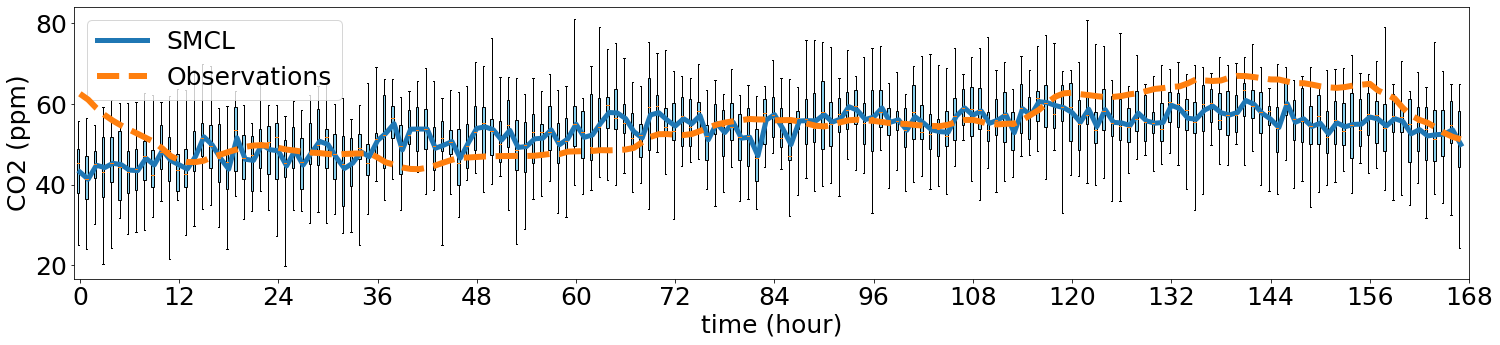

In [12]:
start_day = 0
end_day = start_day+7
day_hide = start_day+1
tick_step = 12

netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=0, burnin=0)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]


plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100)

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

#### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

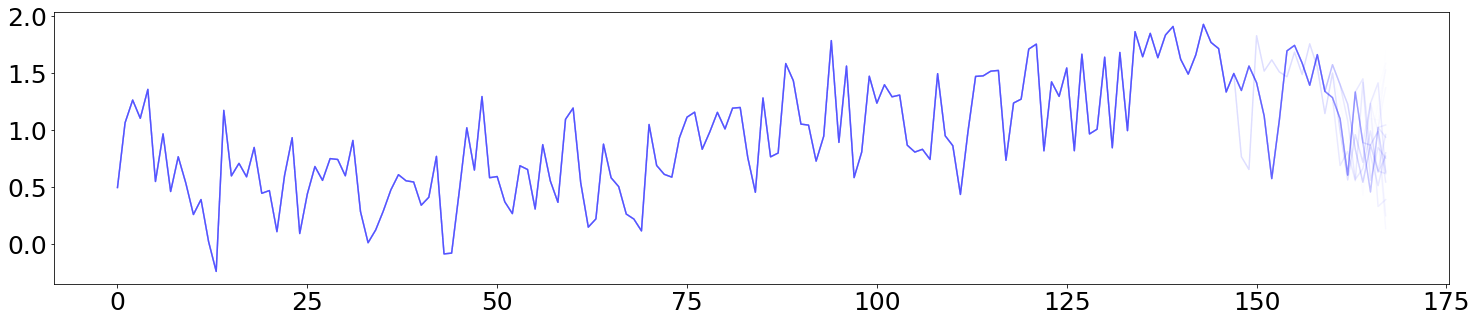

In [13]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I)

batch_idx = 0

netout = netout[:, batch_idx, :, idx_out].numpy()
w = model.smcl.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')